In [14]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [15]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [46]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

## Human

In [17]:
min_samples = 10

In [18]:
ca = cerberus.read(cerberus_h5)

In [35]:
df = ca.triplets.copy(deep=True)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
0,v40,ENSG00000000003,3.0,4.0,5.0,5.0,1.428571,0.355932,0.474576,0.169492,mixed,TSPAN6,NaN,NaN
1,v40,ENSG00000000005,2.0,2.0,2.0,2.0,1.000000,0.400000,0.400000,0.200000,mixed,TNMD,NaN,NaN
2,v40,ENSG00000000419,7.0,6.0,16.0,16.0,2.461538,0.452736,0.388060,0.159204,mixed,DPM1,NaN,NaN
3,v40,ENSG00000000457,3.0,4.0,5.0,5.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN
4,v40,ENSG00000000460,5.0,5.0,9.0,9.0,1.800000,0.423729,0.423729,0.152542,mixed,C1orf112,NaN,NaN


In [38]:
# limit to sample_det
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']

# for each gene, compute the mode sector
temp = df[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# which samples have the same sector as mode?
df['same_as_mode'] = df.sector==df.mode_sector
df.head()

# what % of samples / gene have the same sector?
temp = df[['gid', 'same_as_mode', 'mode_sector', 'sample']].groupby(['gid', 'same_as_mode', 'mode_sector']).count().reset_index().rename({'sample':'n_samples'}, axis=1)
temp2 = df[['gid', 'sample']].groupby('gid').count().reset_index().rename({'sample':'n_tot_samples'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# remove things that are only expressed in a few samples
temp = temp.loc[temp.n_tot_samples >= min_samples]
temp['perc'] = (temp.n_samples/temp.n_tot_samples)*100

# remove things that are all simple
temp = temp.loc[temp.mode_sector != 'simple']

# now get the 2nd mode
temp2 = df.loc[df.same_as_mode==False]
temp2 = temp2[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector_2'}, axis=1)
temp = temp.merge(temp2, 
                  on='gid',
                  how='left')

# add biotype info
df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
temp = temp.merge(df[['gid_stable',
                      'gname',
                      'biotype_category']].rename({'gid_stable':'gid'}, axis=1),
                      how='left', on='gid')

In [39]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,protein_coding
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,protein_coding
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,protein_coding
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,protein_coding
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,protein_coding


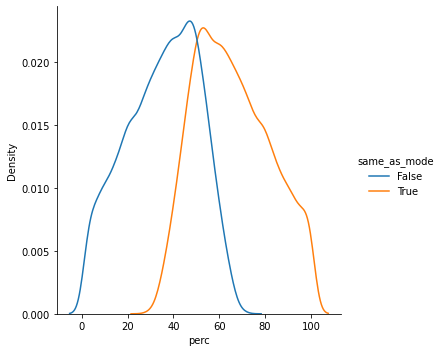

In [7]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode',
                 common_norm=False,
                 kind='kde')
                 

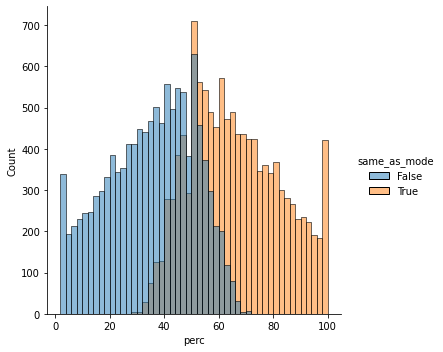

In [8]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode')

In [9]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc
0,ENSG00000000003,False,tes,4,42,9.523810
1,ENSG00000000003,True,tes,38,42,90.476190
3,ENSG00000000419,False,mixed,24,51,47.058824
4,ENSG00000000419,True,mixed,27,51,52.941176
5,ENSG00000000457,False,mixed,27,49,55.102041


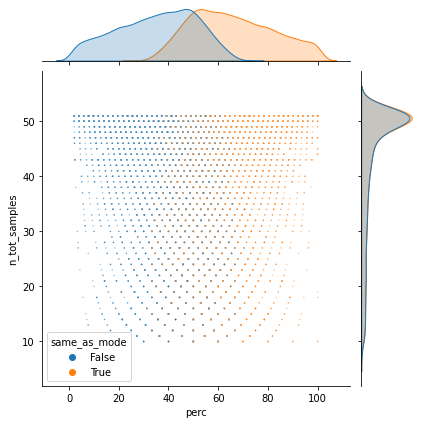

In [10]:
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   hue='same_as_mode',
                   joint_kws={'s':2,
                              'alpha':0.5})

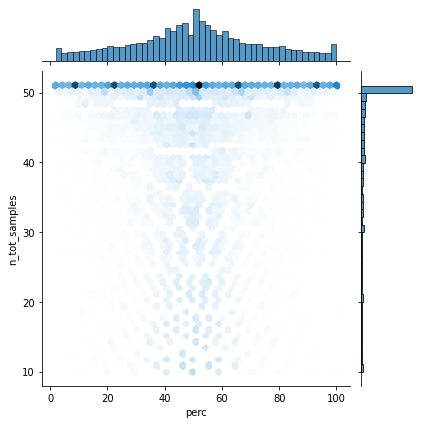

In [11]:
temp2 = temp.loc[temp.same_as_mode==True] 
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   kind='hex')

In [12]:
# look at max. number of isoforms
temp2 = df[['gid', 'n_iso']].groupby('gid').max().rename({'n_iso':'max_n_iso'}, axis=1).reset_index()
temp = temp.merge(temp2, 
                  how='left',
                  on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,max_n_iso
0,ENSG00000000003,False,tes,4,42,9.523810,19.0
1,ENSG00000000003,True,tes,38,42,90.476190,19.0
2,ENSG00000000419,False,mixed,24,51,47.058824,10.0
3,ENSG00000000419,True,mixed,27,51,52.941176,10.0
4,ENSG00000000457,False,mixed,27,49,55.102041,5.0


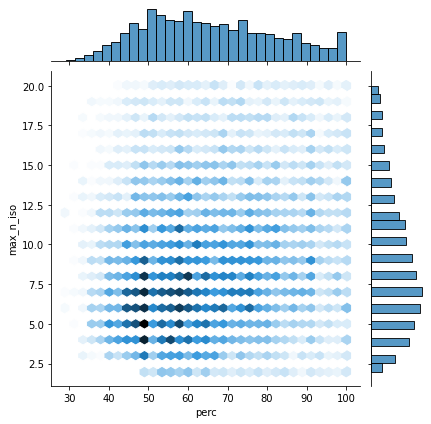

In [13]:
temp2 = temp.loc[temp.same_as_mode==True] 
temp2 = temp2.loc[temp2.max_n_iso<=20]
ax = sns.jointplot(temp2,
                   x='perc',
                   y='max_n_iso',
                   kind='hex')

In [14]:
temp.loc[temp.max_n_iso == 1]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,max_n_iso


## What sectors are the most sample-conserved vs. least?

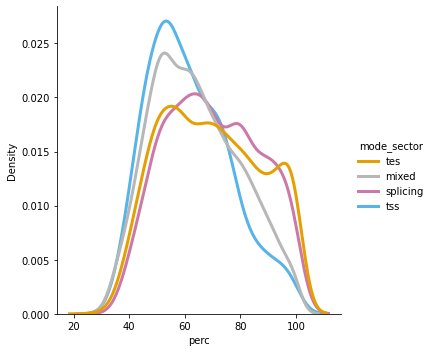

In [15]:
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors()
ax = sns.displot(temp2, 
                 x='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 kind='kde',
                 linewidth=3,
                 common_norm=False)

## What % of these genes have "conserved" behavior across samples?

In [16]:
min_perc = 80

n = len(temp.gid.unique().tolist())
n_num = len(temp.loc[(temp.same_as_mode==True)&(temp.perc>=min_perc)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same sector as the mode')

22.89% (2700/11796) genes have >=80% of expressed samples in the same sector as the mode


## What % of these genes have "conserved" behavior across samples; by mode sector

In [17]:
min_perc = 80

for s in temp.mode_sector.unique().tolist():
    temp2 = temp.loc[temp.mode_sector==s]
    n = len(temp2.gid.unique().tolist())
    n_num = len(temp2.loc[(temp2.same_as_mode==True)&(temp2.perc>=min_perc)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same {s} sector as the mode')

31.67% (865/2731) genes have >=80% of expressed samples in the same tes sector as the mode
18.98% (1306/6880) genes have >=80% of expressed samples in the same mixed sector as the mode
31.94% (427/1337) genes have >=80% of expressed samples in the same splicing sector as the mode
12.03% (102/848) genes have >=80% of expressed samples in the same tss sector as the mode


## What are common mode-2nd mode pairings?

In [40]:
temp2 = temp[['gid', 'mode_sector', 'mode_sector_2']].groupby(['mode_sector', 'mode_sector_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
off_list = ['mixed', 'simple']
temp2.loc[~(temp2.mode_sector.isin(off_list))&\
          ~(temp2.mode_sector_2.isin(off_list))]

,mode_sector,mode_sector_2,n_genes
6,splicing,tes,2
7,splicing,tss,4
10,tes,splicing,4
11,tes,tss,16
14,tss,tes,6


In [41]:
temp.loc[(temp.mode_sector=='tes')&\
         (temp.mode_sector_2=='tss')]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
3149,ENSG00000100036,False,tes,30,43,69.767442,tss,SLC35E4,protein_coding
3150,ENSG00000100036,True,tes,13,43,30.232558,tss,SLC35E4,protein_coding
6621,ENSG00000116903,False,tes,26,46,56.521739,tss,EXOC8,protein_coding
6622,ENSG00000116903,True,tes,20,46,43.478261,tss,EXOC8,protein_coding
8835,ENSG00000131016,False,tes,17,37,45.945946,tss,AKAP12,protein_coding
8836,ENSG00000131016,True,tes,20,37,54.054054,tss,AKAP12,protein_coding
9130,ENSG00000132467,False,tes,30,51,58.823529,tss,UTP3,protein_coding
9131,ENSG00000132467,True,tes,21,51,41.176471,tss,UTP3,protein_coding
19483,ENSG00000185619,False,tes,27,51,52.941176,tss,PCGF3,protein_coding
19484,ENSG00000185619,True,tes,24,51,47.058824,tss,PCGF3,protein_coding


## Plot a few examples

In [36]:
# first save
temp.to_csv('sample_sector_mode_cons.tsv', sep='\t', index=False)

In [5]:
ca = cerberus.read(cerberus_h5)

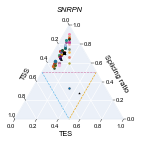

In [19]:
gene = 'SNRPN'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

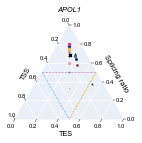

In [20]:
gene = 'APOL1'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

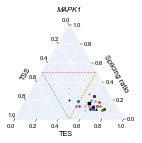

In [21]:
gene = 'MAPK1'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

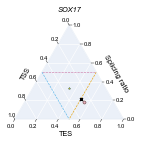

In [23]:
gene = 'SOX17'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

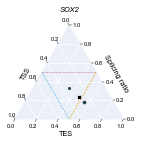

In [25]:
gene = 'SOX2'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

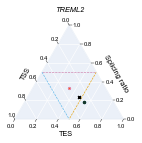

In [26]:
gene = 'TREML2'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

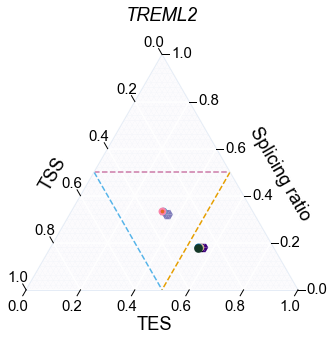

In [7]:
gene = 'TREML2'
plot_sample_det_density_simplex(ca, gene)

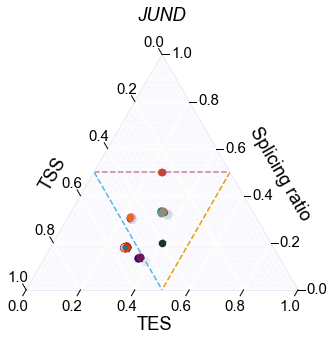

In [8]:
gene = 'JUND'
plot_sample_det_density_simplex(ca, gene)

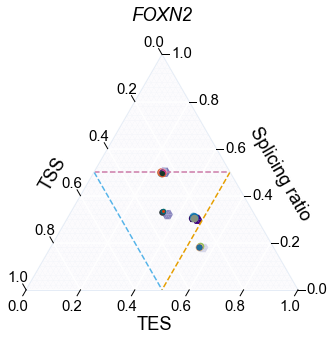

In [9]:
gene = 'FOXN2'
plot_sample_det_density_simplex(ca, gene)

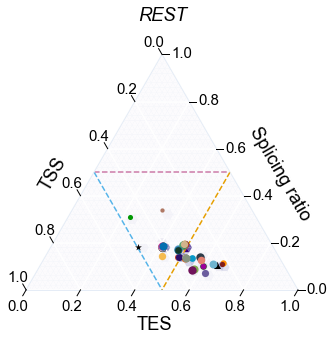

In [10]:
gene = 'REST'
plot_sample_det_density_simplex(ca, gene)

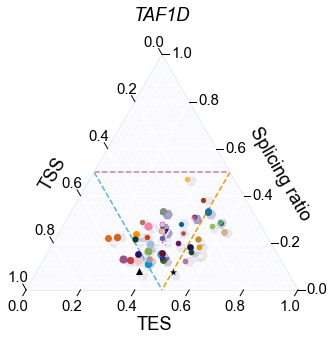

In [11]:
gene = 'TAF1D'
plot_sample_det_density_simplex(ca, gene)

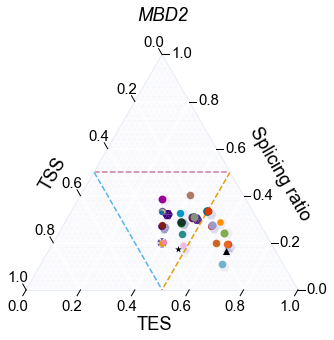

In [12]:
gene = 'MBD2'
plot_sample_det_density_simplex(ca, gene)

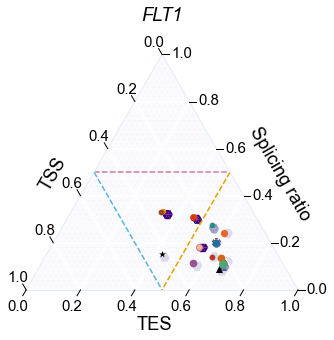

In [13]:
gene = 'FLT1'
plot_sample_det_density_simplex(ca, gene)

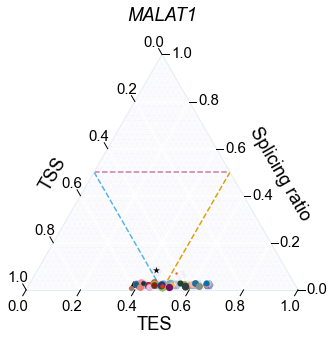

In [31]:
gene = 'MALAT1'
plot_sample_det_density_simplex(ca, gene)

In [42]:
# ca.triplets.loc[(ca.triplets.gname=='MALAT1')&\
#                 (ca.triplets.source=='sample_det')]

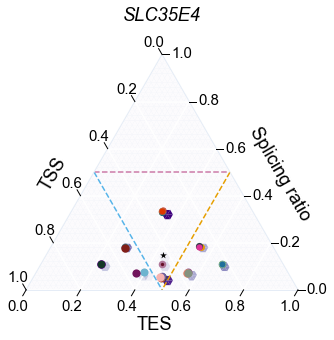

In [43]:
gene = 'SLC35E4'
plot_sample_det_density_simplex(ca, gene)

In [45]:
ca.triplets.loc[(ca.triplets.gname==gene)&\
                (ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
1443,sample_det,ENSG00000100036,2.0,3.0,1.0,4.0,0.400000,0.370370,0.555556,0.074074,tes,SLC35E4,hffc6,22.104858
14644,sample_det,ENSG00000100036,3.0,3.0,1.0,6.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,colon,37.666340
30265,sample_det,ENSG00000100036,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SLC35E4,hl60_m1_12hr,4.117906
41101,sample_det,ENSG00000100036,3.0,3.0,1.0,5.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,ovary,10.836935
56390,sample_det,ENSG00000100036,3.0,3.0,1.0,5.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,hct116,18.746954
80929,sample_det,ENSG00000100036,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,SLC35E4,calu3,10.762908
93152,sample_det,ENSG00000100036,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SLC35E4,caco2,3.404667
106235,sample_det,ENSG00000100036,3.0,1.0,1.0,3.0,0.500000,0.666667,0.222222,0.111111,tss,SLC35E4,huvec,35.462524
118619,sample_det,ENSG00000100036,3.0,3.0,1.0,7.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,heart,16.557146
136468,sample_det,ENSG00000100036,3.0,3.0,1.0,6.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,gm12878,11.769158


## Are species-conserved genes more likely to be sample conserved?

In [70]:
df = pd.read_csv(human_mouse_sect_cons, sep='\t')
print(len(df.index))
df['sector_conserved'] = df.sector_human == df.sector_mouse
df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
df['dist']

13494


KeyError: 'dist'

In [51]:
temp = pd.read_csv('sample_sector_mode_cons.tsv', sep='\t')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,TSPAN6,protein_coding
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,DPM1,protein_coding
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,DPM1,protein_coding
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,SCYL3,protein_coding


In [52]:
df = df[['Gene stable ID', 'sector_conserved', 'sector_human', 'sector_mouse']]
df.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
temp = temp.merge(df, how='inner', on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category,sector_conserved,sector_human,sector_mouse
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,TSPAN6,protein_coding,True,tes,tes
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding,True,tes,tes
2,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,SCYL3,protein_coding,True,mixed,mixed
3,ENSG00000000457,True,mixed,22,49,44.897959,simple,SCYL3,SCYL3,protein_coding,True,mixed,mixed
4,ENSG00000000460,False,mixed,19,46,41.304348,simple,C1orf112,C1orf112,protein_coding,True,tes,tes


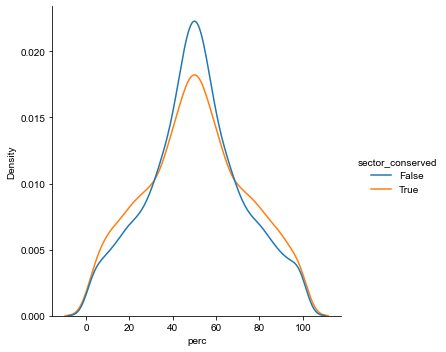

In [56]:
temp2 = temp.loc[temp.same_as_mode==True].copy(deep=True)
sns.displot(temp, x='perc',
            hue='sector_conserved',
            kind='kde',
            common_norm=False)

## Compare the mouse mode to the human mode

In [65]:
# get the orths
df = pd.read_csv(human_mouse_sect_cons, sep='\t')
df.head()
df = df[['Gene stable ID', 'Mouse gene stable ID']].rename({'Gene stable ID': 'gid_human',
                                                            'Mouse gene stable ID': 'gid_mouse'}, 
                                                           axis=1)
df.head()

,gid_human,gid_mouse
0,ENSG00000065135,ENSMUSG00000000001
1,ENSG00000093009,ENSMUSG00000000028
2,ENSG00000102098,ENSMUSG00000000037
3,ENSG00000141562,ENSMUSG00000000056
4,ENSG00000105971,ENSMUSG00000000058


In [62]:
temp = pd.read_csv('sample_sector_mode_cons.tsv', sep='\t')
temp.rename({'gid':'gid_human'}, axis=1, inplace=True)
temp2 = pd.read_csv('mouse_sample_sector_mode_cons.tsv', sep='\t')
temp2.rename({'gid':'gid_mouse'}, axis=1, inplace=True)

In [66]:
df = df.merge(temp,
              how='inner',
              on='gid_human',
              suffixes=('', '_human'))
df = df.merge(temp2,
              how='inner',
              on='gid_mouse',
              suffixes=('', '_mouse'))

In [68]:
df['mode_sector_conserved'] = df['mode_sector'] == df['mode_sector_mouse']

In [69]:
df.head()

,gid_human,gid_mouse,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,...,same_as_mode_mouse,mode_sector_mouse,n_samples_mouse,n_tot_samples_mouse,perc_mouse,mode_sector_2_mouse,gname,biotype_category_mouse,max_n_iso,mode_sector_conserved
0,ENSG00000093009,ENSMUSG00000000028,False,splicing,16,46,34.782609,mixed,CDC45,CDC45,...,False,mixed,12,32,37.5,tss,Cdc45,protein_coding,6.0,False
1,ENSG00000093009,ENSMUSG00000000028,False,splicing,16,46,34.782609,mixed,CDC45,CDC45,...,True,mixed,20,32,62.5,tss,Cdc45,protein_coding,6.0,False
2,ENSG00000093009,ENSMUSG00000000028,True,splicing,30,46,65.217391,mixed,CDC45,CDC45,...,False,mixed,12,32,37.5,tss,Cdc45,protein_coding,6.0,False
3,ENSG00000093009,ENSMUSG00000000028,True,splicing,30,46,65.217391,mixed,CDC45,CDC45,...,True,mixed,20,32,62.5,tss,Cdc45,protein_coding,6.0,False
4,ENSG00000141562,ENSMUSG00000000056,False,splicing,21,51,41.176471,mixed,NARF,NARF,...,True,mixed,32,32,100.0,NaN,Narf,protein_coding,6.0,False
